In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Load data
df = pd.read_csv('../clean_dbt_district_wise.csv')

# Filter for latest year
df_2023 = df[df['fy'] == '2023-2024'].copy()

print("="*80)
print("DBT DISTRICT-WISE CLUSTERING ANALYSIS")
print("="*80)
print(f"\nDataset Shape: {df_2023.shape}")
print(f"Number of Districts: {df_2023['district_name'].nunique()}")
print(f"Number of States: {df_2023['state_name'].nunique()}")

# Feature Engineering
df_2023['total_dbt_transfer_cr'] = df_2023['total_dbt_transfer'] / 1e7
df_2023['transactions_lakhs'] = df_2023['no_of_dbt_transactions'] / 1e5

# Select features for clustering
features = ['total_dbt_transfer', 'no_of_dbt_transactions', 'transfer_per_transaction']
X = df_2023[features].fillna(df_2023[features].median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create feature names for plotting
feature_names = ['Total Transfer', 'No. of Transactions', 'Transfer per Transaction']

print("\n" + "="*80)
print("FEATURE STATISTICS")
print("="*80)
print(df_2023[features].describe())


DBT DISTRICT-WISE CLUSTERING ANALYSIS

Dataset Shape: (765, 9)
Number of Districts: 760
Number of States: 36

FEATURE STATISTICS
       total_dbt_transfer  no_of_dbt_transactions  transfer_per_transaction
count        7.650000e+02            7.650000e+02                761.000000
mean         1.288919e+09            1.058173e+06               1846.396228
std          1.101812e+09            1.558205e+06               2072.532221
min          0.000000e+00            0.000000e+00                 76.244040
25%          4.401924e+08            3.064870e+05                919.493308
50%          1.056801e+09            6.844210e+05               1536.534750
75%          1.817821e+09            1.223958e+06               2281.985401
max          6.096122e+09            2.112930e+07              45853.952521



1. K-MEANS CLUSTERING


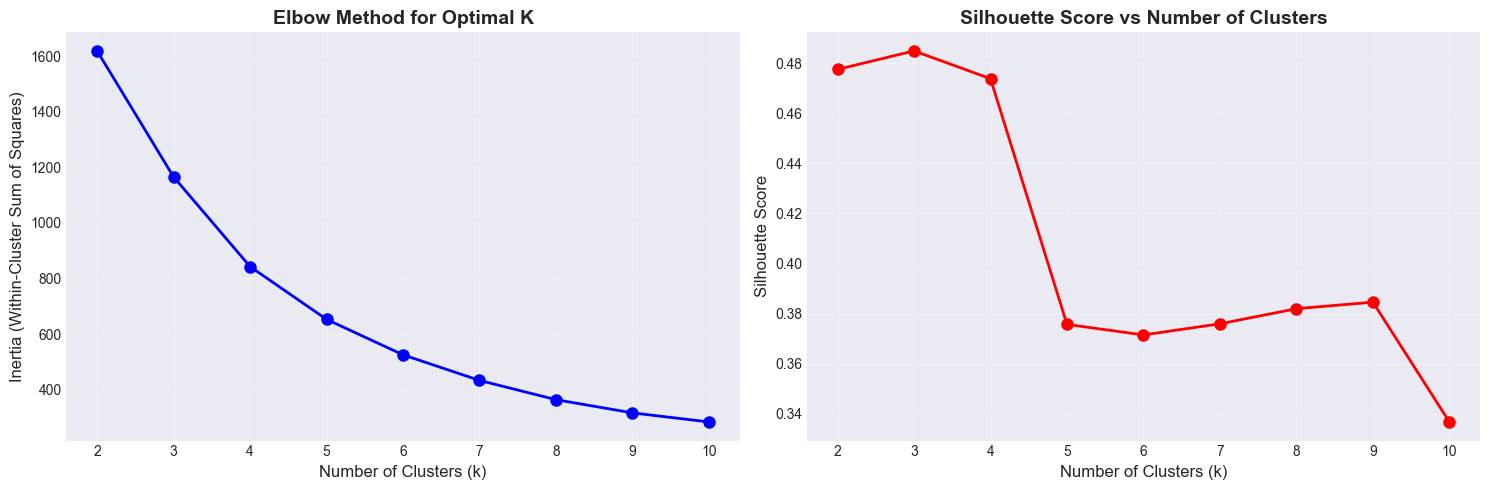


Optimal number of clusters: 4
Silhouette Score: 0.4739
Davies-Bouldin Score: 0.6032
Calinski-Harabasz Score: 436.9971

K-Means Cluster Statistics:
--------------------------------------------------------------------------------
                Count  Avg Transfer (Cr)  Avg Transactions (L)  Avg Per Txn
kmeans_cluster                                                             
0                 181             284.55                 20.05      1901.71
1                 576              79.04                  6.20      1772.30
2                   7             214.08                127.65       184.29
3                   1              74.94                  0.16     45853.95


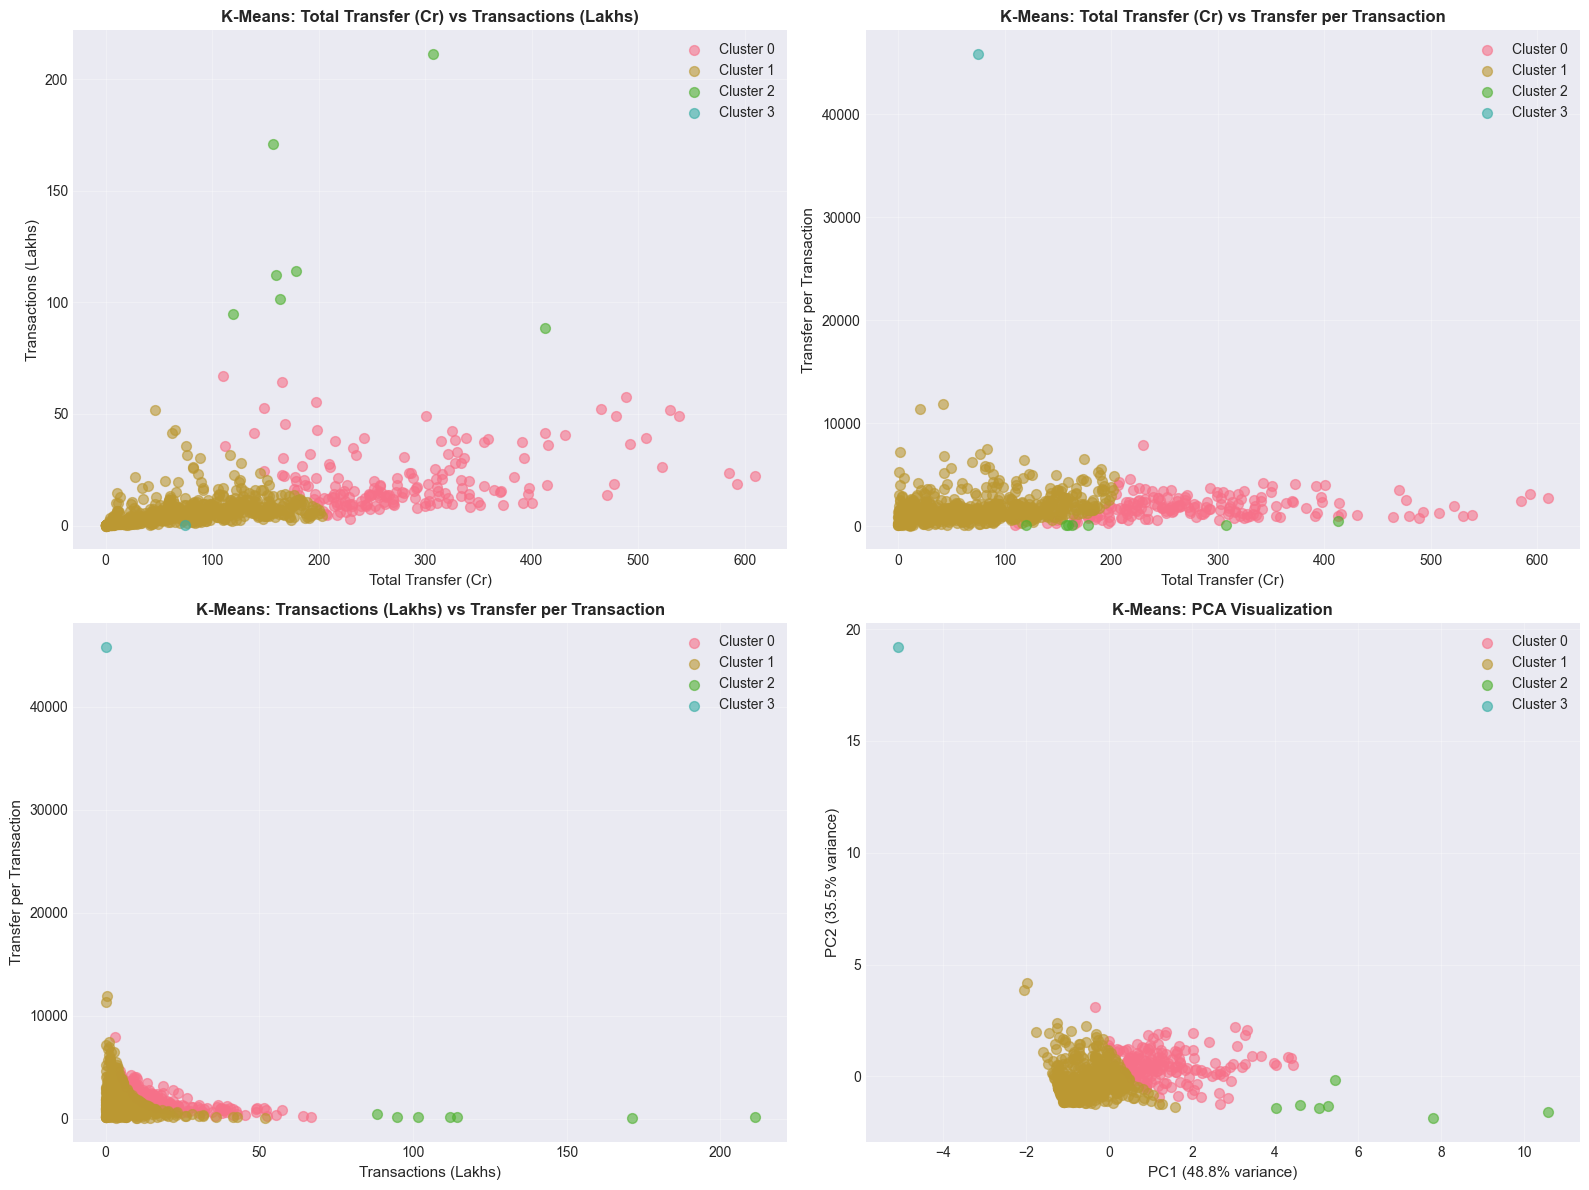

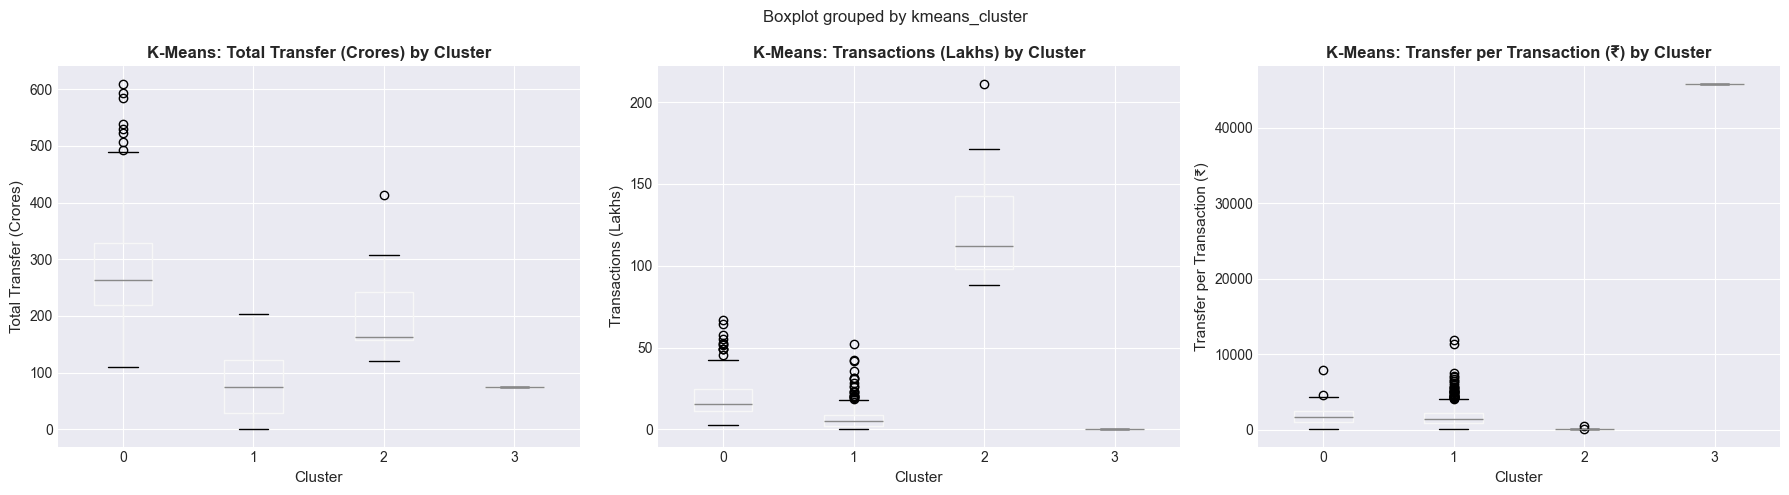

In [4]:
# ============================================================================
# 1. K-MEANS CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("1. K-MEANS CLUSTERING")
print("="*80)

# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_kmeans_optimal_k.png', dpi=300, bbox_inches='tight')
plt.show()

# Optimal K-Means with k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_2023['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nOptimal number of clusters: {optimal_k}")
print(f"Silhouette Score: {silhouette_score(X_scaled, df_2023['kmeans_cluster']):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, df_2023['kmeans_cluster']):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, df_2023['kmeans_cluster']):.4f}")

# K-Means Cluster Statistics
print("\nK-Means Cluster Statistics:")
print("-"*80)
kmeans_stats = df_2023.groupby('kmeans_cluster').agg({
    'district_name': 'count',
    'total_dbt_transfer_cr': 'mean',
    'transactions_lakhs': 'mean',
    'transfer_per_transaction': 'mean'
}).round(2)
kmeans_stats.columns = ['Count', 'Avg Transfer (Cr)', 'Avg Transactions (L)', 'Avg Per Txn']
print(kmeans_stats)

# Visualize K-Means Clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2D Scatter plots
scatter_configs = [
    ('total_dbt_transfer_cr', 'transactions_lakhs', 'Total Transfer (Cr)', 'Transactions (Lakhs)'),
    ('total_dbt_transfer_cr', 'transfer_per_transaction', 'Total Transfer (Cr)', 'Transfer per Transaction'),
    ('transactions_lakhs', 'transfer_per_transaction', 'Transactions (Lakhs)', 'Transfer per Transaction')
]

for idx, (x_col, y_col, x_label, y_label) in enumerate(scatter_configs[:3]):
    ax = axes[idx // 2, idx % 2]
    for cluster in range(optimal_k):
        cluster_data = df_2023[df_2023['kmeans_cluster'] == cluster]
        ax.scatter(cluster_data[x_col], cluster_data[y_col], 
                  label=f'Cluster {cluster}', alpha=0.6, s=50)
    
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(f'K-Means: {x_label} vs {y_label}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_2023['pca1'] = X_pca[:, 0]
df_2023['pca2'] = X_pca[:, 1]

ax = axes[1, 1]
for cluster in range(optimal_k):
    cluster_data = df_2023[df_2023['kmeans_cluster'] == cluster]
    ax.scatter(cluster_data['pca1'], cluster_data['pca2'], 
              label=f'Cluster {cluster}', alpha=0.6, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax.set_title('K-Means: PCA Visualization', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_kmeans_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Box plots for K-Means
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (col, title) in enumerate([
    ('total_dbt_transfer_cr', 'Total Transfer (Crores)'),
    ('transactions_lakhs', 'Transactions (Lakhs)'),
    ('transfer_per_transaction', 'Transfer per Transaction (₹)')
]):
    df_2023.boxplot(column=col, by='kmeans_cluster', ax=axes[idx])
    axes[idx].set_xlabel('Cluster', fontsize=11)
    axes[idx].set_ylabel(title, fontsize=11)
    axes[idx].set_title(f'K-Means: {title} by Cluster', fontsize=12, fontweight='bold')
    plt.sca(axes[idx])
    plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('03_kmeans_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()



2. HIERARCHICAL CLUSTERING


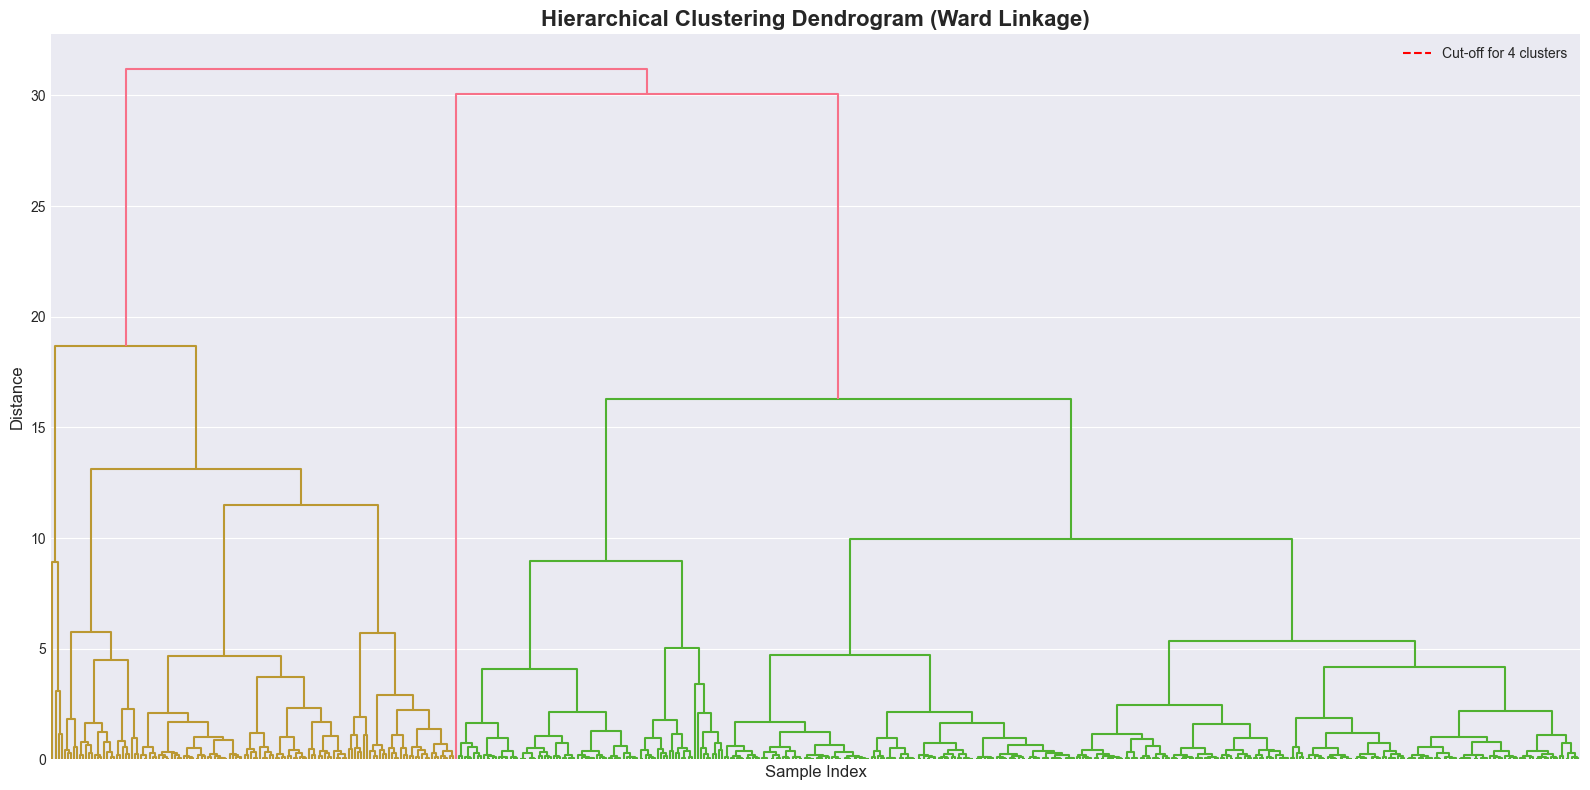


Silhouette Score: 0.4757
Davies-Bouldin Score: 0.5659
Calinski-Harabasz Score: 403.5000

Hierarchical Cluster Statistics:
--------------------------------------------------------------------------------
                      Count  Avg Transfer (Cr)  Avg Transactions (L)  \
hierarchical_cluster                                                   
0                       623              87.95                  7.23   
1                       134             315.20                 20.14   
2                         1              74.94                  0.16   
3                         7             214.08                127.65   

                      Avg Per Txn  
hierarchical_cluster               
0                         1772.92  
1                         1944.21  
2                        45853.95  
3                          184.29  


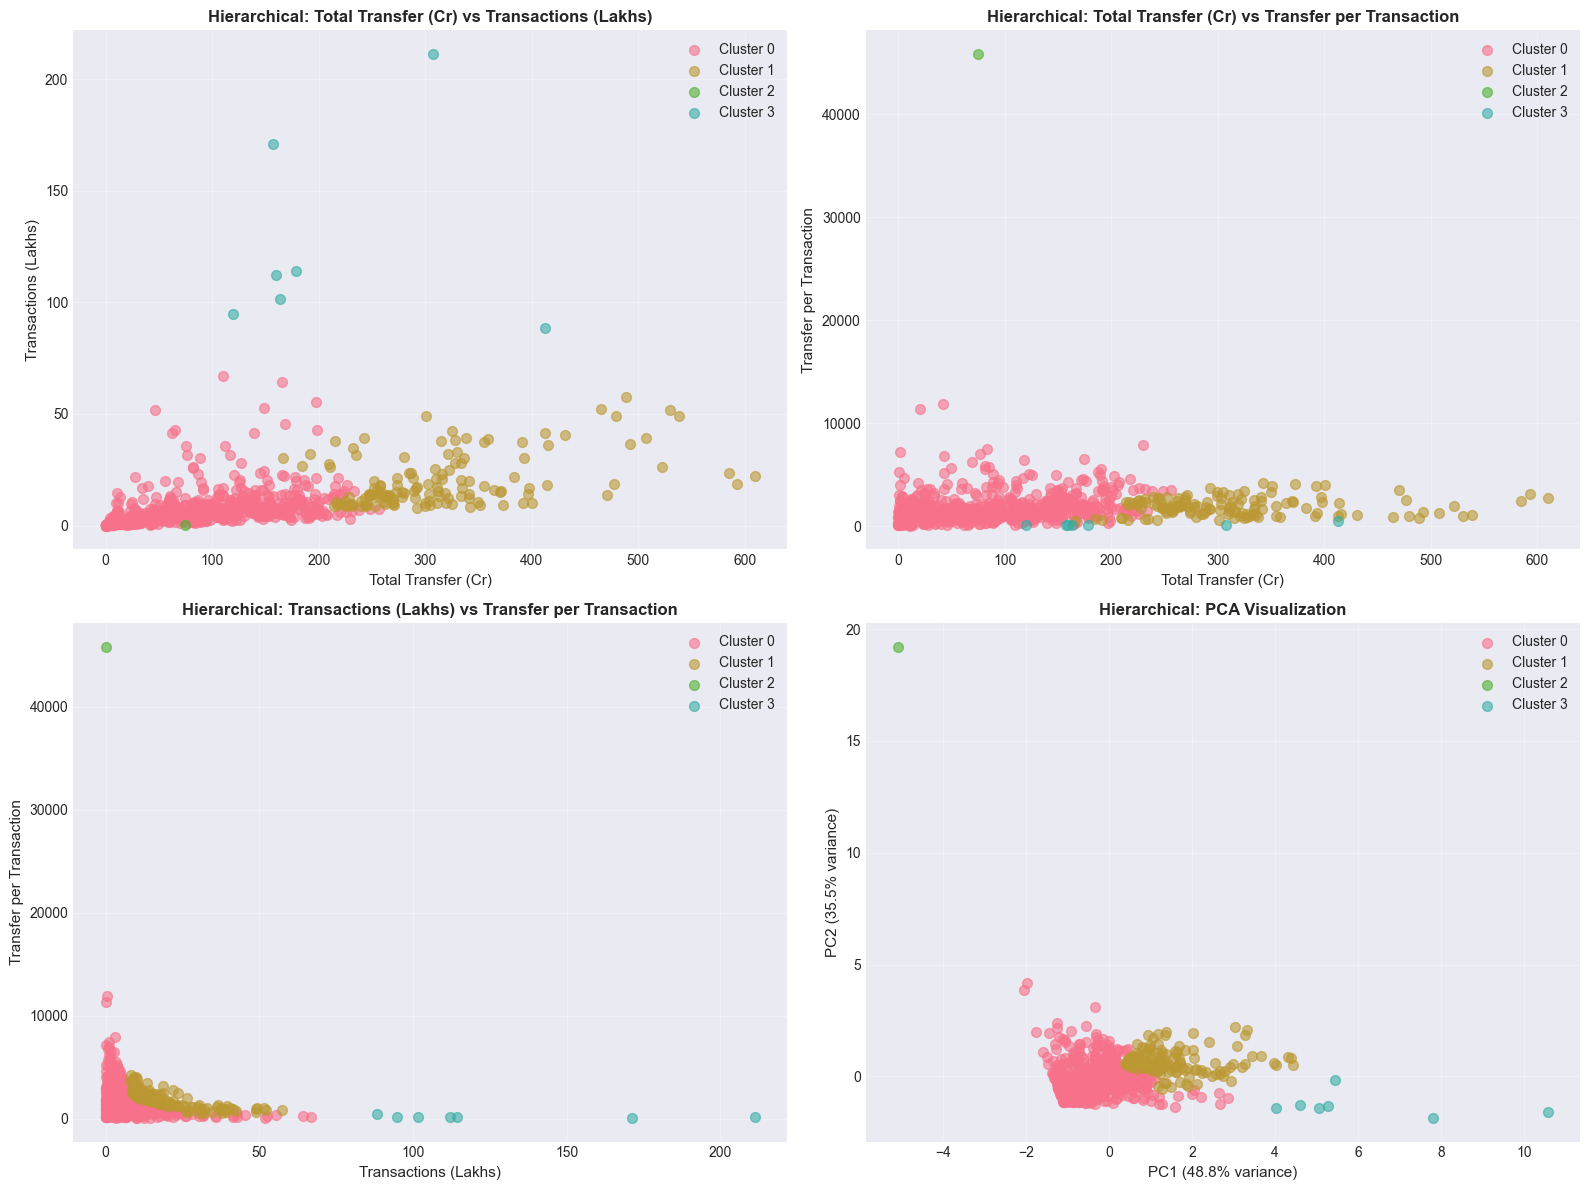

In [5]:
# ============================================================================
# 2. HIERARCHICAL CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("2. HIERARCHICAL CLUSTERING")
print("="*80)

# Sample data for dendrogram (use all data if dataset is small)
if len(X_scaled) > 500:
    sample_indices = np.random.choice(len(X_scaled), 500, replace=False)
    X_sample = X_scaled[sample_indices]
else:
    X_sample = X_scaled

# Create linkage matrix
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, no_labels=True, color_threshold=None)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=50, color='r', linestyle='--', label='Cut-off for 4 clusters')
plt.legend()
plt.tight_layout()
plt.savefig('04_hierarchical_dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Hierarchical clustering with 4 clusters
hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_2023['hierarchical_cluster'] = hierarchical.fit_predict(X_scaled)

print(f"\nSilhouette Score: {silhouette_score(X_scaled, df_2023['hierarchical_cluster']):.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, df_2023['hierarchical_cluster']):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, df_2023['hierarchical_cluster']):.4f}")

# Hierarchical Cluster Statistics
print("\nHierarchical Cluster Statistics:")
print("-"*80)
hierarchical_stats = df_2023.groupby('hierarchical_cluster').agg({
    'district_name': 'count',
    'total_dbt_transfer_cr': 'mean',
    'transactions_lakhs': 'mean',
    'transfer_per_transaction': 'mean'
}).round(2)
hierarchical_stats.columns = ['Count', 'Avg Transfer (Cr)', 'Avg Transactions (L)', 'Avg Per Txn']
print(hierarchical_stats)

# Visualize Hierarchical Clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (x_col, y_col, x_label, y_label) in enumerate(scatter_configs[:3]):
    ax = axes[idx // 2, idx % 2]
    for cluster in range(4):
        cluster_data = df_2023[df_2023['hierarchical_cluster'] == cluster]
        ax.scatter(cluster_data[x_col], cluster_data[y_col], 
                  label=f'Cluster {cluster}', alpha=0.6, s=50)
    
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(f'Hierarchical: {x_label} vs {y_label}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# PCA visualization
ax = axes[1, 1]
for cluster in range(4):
    cluster_data = df_2023[df_2023['hierarchical_cluster'] == cluster]
    ax.scatter(cluster_data['pca1'], cluster_data['pca2'], 
              label=f'Cluster {cluster}', alpha=0.6, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax.set_title('Hierarchical: PCA Visualization', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('05_hierarchical_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


3. DBSCAN CLUSTERING


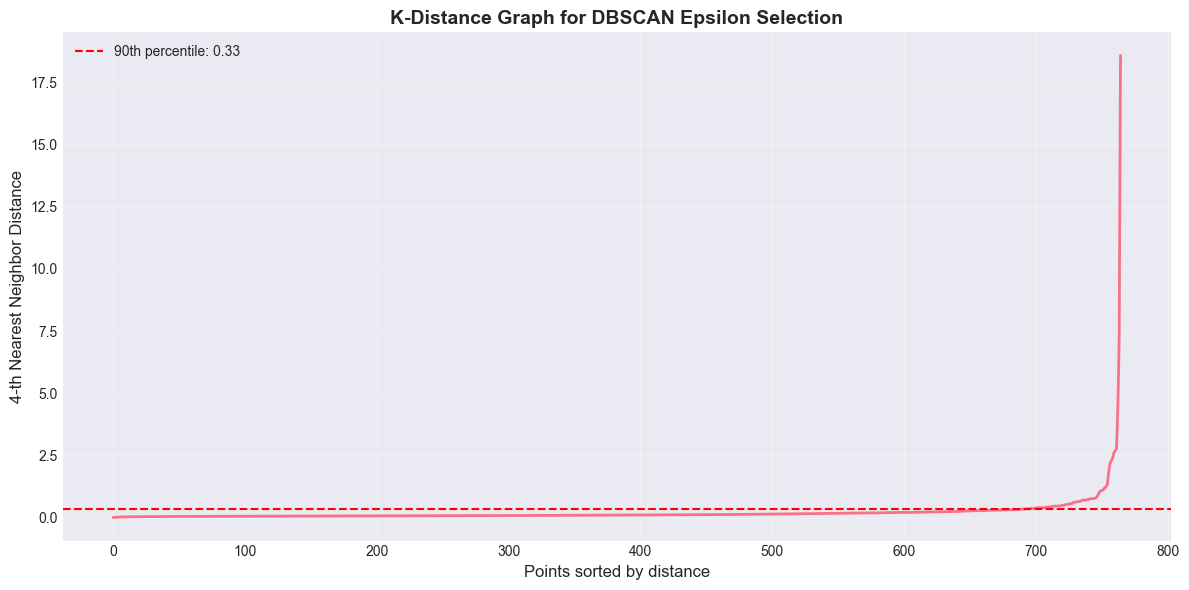


Epsilon: 0.3332
Number of clusters: 5
Number of noise points: 53 (6.93%)
Silhouette Score: 0.2402

DBSCAN Cluster Statistics:
--------------------------------------------------------------------------------
                Count  Avg Transfer (Cr)  Avg Transactions (L)  Avg Per Txn
dbscan_cluster                                                             
0                 696             115.03                  7.66      1761.13
1                   3              93.97                 31.26       300.51
2                   9             359.88                 38.76       931.42
3                   4             376.82                  9.30      4061.37


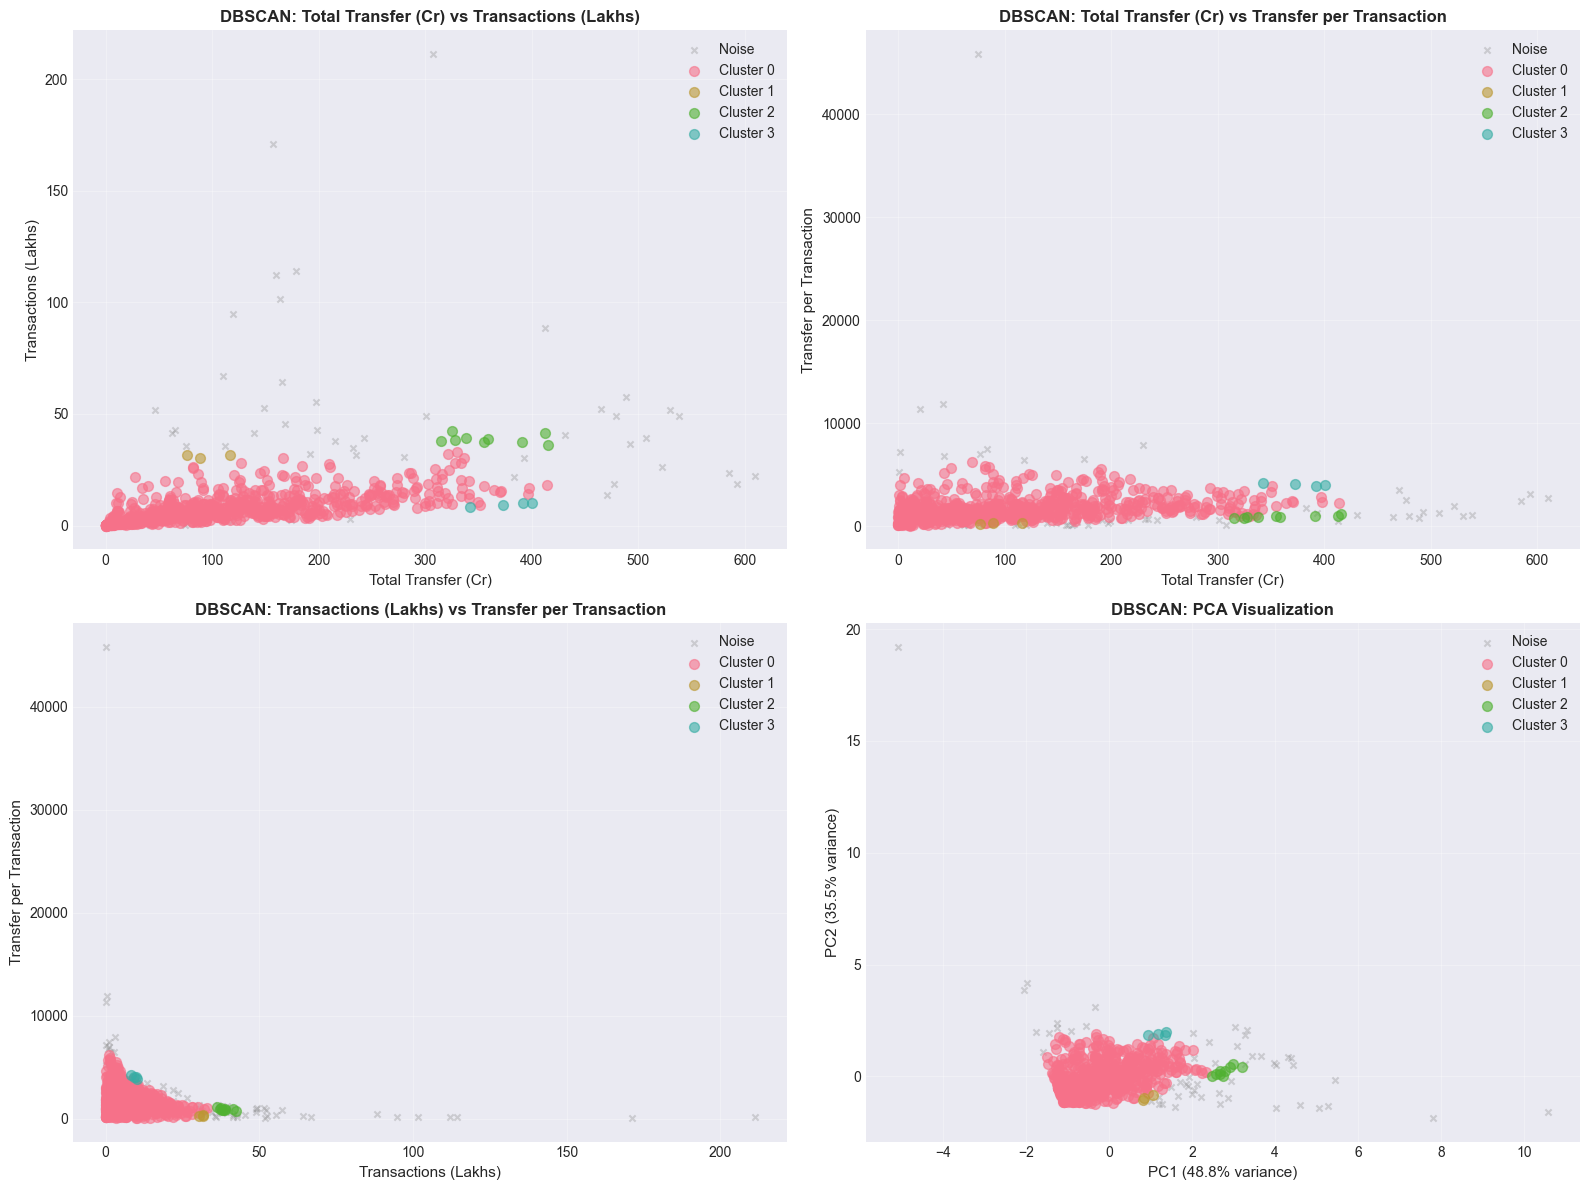

In [6]:
# ============================================================================
# 3. DBSCAN CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("3. DBSCAN CLUSTERING")
print("="*80)

# Find optimal epsilon using k-distance graph
k = 4
distances = []
for point in X_scaled:
    dist = cdist([point], X_scaled, metric='euclidean')
    dist = np.sort(dist[0])
    distances.append(dist[k])

distances = np.sort(distances)

plt.figure(figsize=(12, 6))
plt.plot(distances, linewidth=2)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph for DBSCAN Epsilon Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=np.percentile(distances, 90), color='r', linestyle='--', 
            label=f'90th percentile: {np.percentile(distances, 90):.2f}')
plt.legend()
plt.tight_layout()
plt.savefig('06_dbscan_epsilon.png', dpi=300, bbox_inches='tight')
plt.show()

# DBSCAN with optimal parameters
eps = np.percentile(distances, 90)
dbscan = DBSCAN(eps=eps, min_samples=5)
df_2023['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

n_clusters = len(set(df_2023['dbscan_cluster'])) - (1 if -1 in df_2023['dbscan_cluster'] else 0)
n_noise = list(df_2023['dbscan_cluster']).count(-1)

print(f"\nEpsilon: {eps:.4f}")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise} ({n_noise/len(df_2023)*100:.2f}%)")

if n_clusters > 0:
    core_samples = df_2023[df_2023['dbscan_cluster'] != -1]
    if len(set(core_samples['dbscan_cluster'])) > 1:
        print(f"Silhouette Score: {silhouette_score(X_scaled[df_2023['dbscan_cluster'] != -1], core_samples['dbscan_cluster']):.4f}")

# DBSCAN Cluster Statistics
print("\nDBSCAN Cluster Statistics:")
print("-"*80)
dbscan_stats = df_2023[df_2023['dbscan_cluster'] != -1].groupby('dbscan_cluster').agg({
    'district_name': 'count',
    'total_dbt_transfer_cr': 'mean',
    'transactions_lakhs': 'mean',
    'transfer_per_transaction': 'mean'
}).round(2)
dbscan_stats.columns = ['Count', 'Avg Transfer (Cr)', 'Avg Transactions (L)', 'Avg Per Txn']
print(dbscan_stats)

# Visualize DBSCAN Clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (x_col, y_col, x_label, y_label) in enumerate(scatter_configs[:3]):
    ax = axes[idx // 2, idx % 2]
    
    # Plot noise points
    noise = df_2023[df_2023['dbscan_cluster'] == -1]
    if len(noise) > 0:
        ax.scatter(noise[x_col], noise[y_col], 
                  c='gray', label='Noise', alpha=0.3, s=20, marker='x')
    
    # Plot clusters
    for cluster in sorted(df_2023[df_2023['dbscan_cluster'] != -1]['dbscan_cluster'].unique()):
        cluster_data = df_2023[df_2023['dbscan_cluster'] == cluster]
        ax.scatter(cluster_data[x_col], cluster_data[y_col], 
                  label=f'Cluster {cluster}', alpha=0.6, s=50)
    
    ax.set_xlabel(x_label, fontsize=11)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_title(f'DBSCAN: {x_label} vs {y_label}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# PCA visualization
ax = axes[1, 1]
noise = df_2023[df_2023['dbscan_cluster'] == -1]
if len(noise) > 0:
    ax.scatter(noise['pca1'], noise['pca2'], 
              c='gray', label='Noise', alpha=0.3, s=20, marker='x')

for cluster in sorted(df_2023[df_2023['dbscan_cluster'] != -1]['dbscan_cluster'].unique()):
    cluster_data = df_2023[df_2023['dbscan_cluster'] == cluster]
    ax.scatter(cluster_data['pca1'], cluster_data['pca2'], 
              label=f'Cluster {cluster}', alpha=0.6, s=50)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax.set_title('DBSCAN: PCA Visualization', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('07_dbscan_clusters.png', dpi=300, bbox_inches='tight')
plt.show()



4. MODEL COMPARISON

Clustering Performance Comparison:
--------------------------------------------------------------------------------
   Algorithm  Silhouette Score  Davies-Bouldin Score  Number of Clusters
     K-Means          0.473877              0.603218                   4
Hierarchical          0.475732              0.565946                   4
      DBSCAN          0.240209              0.530208                   5


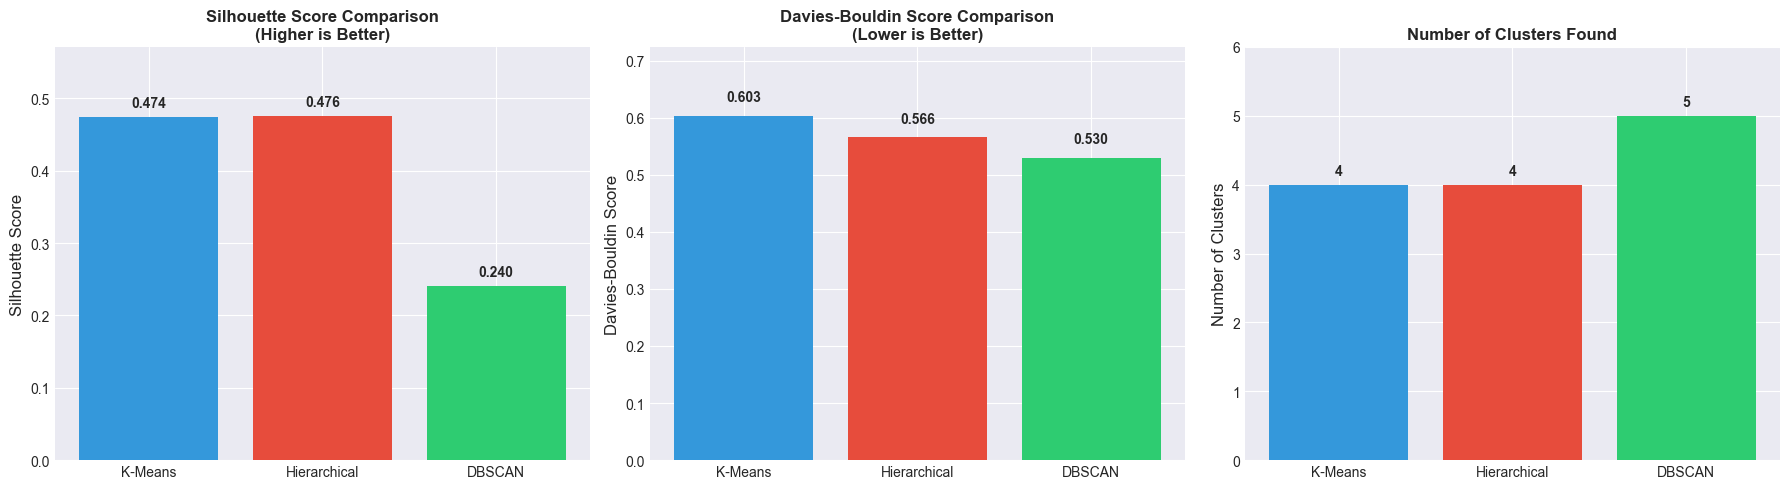

In [7]:
# ============================================================================
# 4. MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("4. MODEL COMPARISON")
print("="*80)

# Prepare comparison data
comparison_data = {
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [
        silhouette_score(X_scaled, df_2023['kmeans_cluster']),
        silhouette_score(X_scaled, df_2023['hierarchical_cluster']),
        silhouette_score(X_scaled[df_2023['dbscan_cluster'] != -1], 
                        df_2023[df_2023['dbscan_cluster'] != -1]['dbscan_cluster']) if n_clusters > 1 else 0
    ],
    'Davies-Bouldin Score': [
        davies_bouldin_score(X_scaled, df_2023['kmeans_cluster']),
        davies_bouldin_score(X_scaled, df_2023['hierarchical_cluster']),
        davies_bouldin_score(X_scaled[df_2023['dbscan_cluster'] != -1], 
                            df_2023[df_2023['dbscan_cluster'] != -1]['dbscan_cluster']) if n_clusters > 1 else 0
    ],
    'Number of Clusters': [
        len(df_2023['kmeans_cluster'].unique()),
        len(df_2023['hierarchical_cluster'].unique()),
        n_clusters
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nClustering Performance Comparison:")
print("-"*80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Scores
axes[0].bar(comparison_df['Algorithm'], comparison_df['Silhouette Score'], 
           color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score Comparison\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(comparison_df['Silhouette Score']) * 1.2)
for i, v in enumerate(comparison_df['Silhouette Score']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Davies-Bouldin Scores
axes[1].bar(comparison_df['Algorithm'], comparison_df['Davies-Bouldin Score'], 
           color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1].set_title('Davies-Bouldin Score Comparison\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_ylim(0, max(comparison_df['Davies-Bouldin Score']) * 1.2)
for i, v in enumerate(comparison_df['Davies-Bouldin Score']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Number of Clusters
axes[2].bar(comparison_df['Algorithm'], comparison_df['Number of Clusters'], 
           color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Number of Clusters', fontsize=12)
axes[2].set_title('Number of Clusters Found', fontsize=12, fontweight='bold')
axes[2].set_ylim(0, max(comparison_df['Number of Clusters']) * 1.2)
for i, v in enumerate(comparison_df['Number of Clusters']):
    axes[2].text(i, v + 0.1, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('08_algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


5. KEY INSIGHTS

Top 10 Districts by Total Transfer (K-Means Clustering):
--------------------------------------------------------------------------------
      District          State  Transfer (Cr)  Transactions (L)  Per Txn (₹)  Cluster
    Mayurbhanj         Odisha     609.612222          22.05740  2763.753760        0
         Kheri  Uttar Pradesh     592.840860          18.69218  3171.598285        0
      Belagavi      Karnataka     584.897885          23.66880  2471.176758        0
    Srikakulam Andhra Pradesh     538.403709          49.13757  1095.706828        0
  Vizianagaram Andhra Pradesh     530.225114          51.63824  1026.807099        0
    Aurangabad    Maharashtra     522.243090          26.39287  1978.727928        0
    Villupuram     Tamil Nadu     507.556932          39.34748  1289.935041        0
Tiruvannamalai     Tamil Nadu     492.384829          36.57772  1346.133189        0
Visakhapatanam Andhra Pradesh     488.569117          57.45546   850.344105    

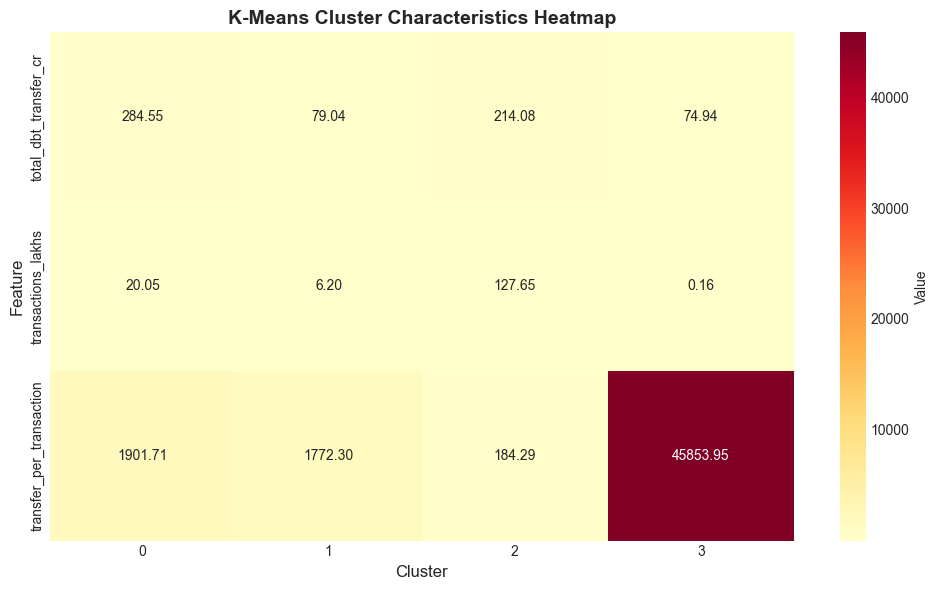

In [8]:
# ============================================================================
# 5. INSIGHTS AND TOP DISTRICTS
# ============================================================================
print("\n" + "="*80)
print("5. KEY INSIGHTS")
print("="*80)

print("\nTop 10 Districts by Total Transfer (K-Means Clustering):")
print("-"*80)
top_districts = df_2023.nlargest(10, 'total_dbt_transfer_cr')[
    ['district_name', 'state_name', 'total_dbt_transfer_cr', 
     'transactions_lakhs', 'transfer_per_transaction', 'kmeans_cluster']
]
top_districts.columns = ['District', 'State', 'Transfer (Cr)', 
                        'Transactions (L)', 'Per Txn (₹)', 'Cluster']
print(top_districts.to_string(index=False))

# State-wise cluster distribution
print("\nState-wise Cluster Distribution (K-Means):")
print("-"*80)
state_clusters = df_2023.groupby(['state_name', 'kmeans_cluster']).size().unstack(fill_value=0)
print(state_clusters.head(10))

# Cluster characteristics
print("\n" + "="*80)
print("CLUSTER CHARACTERISTICS (K-MEANS)")
print("="*80)

for cluster in range(optimal_k):
    cluster_data = df_2023[df_2023['kmeans_cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"  - Number of districts: {len(cluster_data)}")
    print(f"  - Avg Total Transfer: ₹{cluster_data['total_dbt_transfer_cr'].mean():.2f} Cr")
    print(f"  - Avg Transactions: {cluster_data['transactions_lakhs'].mean():.2f} Lakhs")
    print(f"  - Avg Per Transaction: ₹{cluster_data['transfer_per_transaction'].mean():.2f}")
    print(f"  - Top 3 States: {', '.join(cluster_data['state_name'].value_counts().head(3).index.tolist())}")

# Heatmap of cluster characteristics
cluster_summary = df_2023.groupby('kmeans_cluster')[
    ['total_dbt_transfer_cr', 'transactions_lakhs', 'transfer_per_transaction']
].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            cbar_kws={'label': 'Value'})
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('K-Means Cluster Characteristics Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('09_cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()